In [1]:
import torch
import gpytorch
import matplotlib.pyplot as plt
# Generate some random data
train_x = torch.randn(100, 1)
train_y1 = torch.sin(train_x) + torch.randn_like(train_x) * 0.2  # First output
train_y2 = torch.cos(train_x) + torch.randn_like(train_x) * 0.2  # Second output
train_y = torch.cat([train_y1, train_y2], dim=1)  # Combine the outputs

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)    

model.train()
likelihood.train()

# Set optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Training loop
for _ in range(100):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    
    
# Make predictions with the trained model
test_x = torch.linspace(-3, 3, 100).unsqueeze(1)
model.eval()
with torch.no_grad():
    predictions = model(test_x)

# Extract the individual predictions for each output dimension
pred_y1 = predictions.mean[:, 0]
pred_y2 = predictions.mean[:, 1]

/home/oem/v_torch/lib/python3.8/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


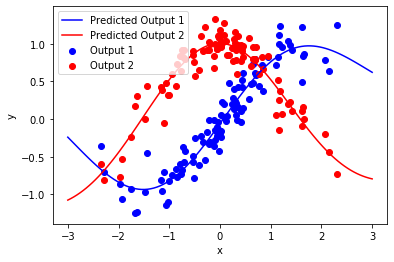

In [2]:
import matplotlib.pyplot as plt

# Plot the training data
plt.scatter(train_x.numpy(), train_y[:, 0].numpy(), color='blue', label='Output 1')
plt.scatter(train_x.numpy(), train_y[:, 1].numpy(), color='red', label='Output 2')

# Plot the predictions
plt.plot(test_x.numpy(), pred_y1.numpy(), color='blue', label='Predicted Output 1')
plt.plot(test_x.numpy(), pred_y2.numpy(), color='red', label='Predicted Output 2')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [3]:
print("Horizontal lenghtscale: ", model.covar_module.data_covar_module.base_kernel.lengthscale.item())
print("Vertical lenghtscale: ", model.covar_module.data_covar_module.outputscale.item())

Horizontal lenghtscale:  1.7589493989944458
Vertical lenghtscale:  0.49022576212882996
